## 1. IMDB 사례

In [3]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
max_features = 10000
maxlen = 100
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          1280000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 94, 32)            28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

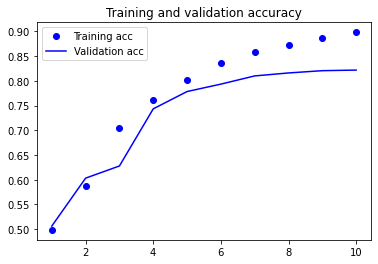

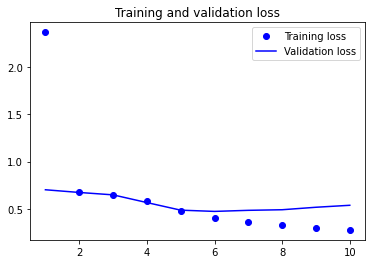

In [5]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

## 2. 온도예측 사례

In [6]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/jena_climate_2009_2016.csv')
df = df.iloc[:,1:].values
mean = df[:200000].mean(axis=0)
df -= mean
std = df[:200000].std(axis=0)
df /= std
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
my_lookback = 1440
my_step = 6
my_delay = 144
my_batch_size = 128

train_gen = generator(df,
                      lookback=my_lookback,
                      delay=my_delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=my_step, 
                      batch_size=my_batch_size)
val_gen = generator(df,
                    lookback=my_lookback,
                    delay=my_delay,
                    min_index=200001,
                    max_index=300000,
                    step=my_step,
                    batch_size=my_batch_size)
test_gen = generator(df,
                     lookback=my_lookback,
                     delay=my_delay,
                     min_index=300001,
                     max_index=None,
                     step=my_step,
                     batch_size=my_batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - my_lookback) // my_batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(df) - 300001 - my_lookback) // my_batch_size

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Conv1D(32, 5, activation='relu',
                        input_shape=(None, df.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20,
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 8s 16ms/step - loss: 0.4876 - val_loss: 0.4212
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3730 - val_loss: 0.4578
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3526 - val_loss: 0.4450
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3333 - val_loss: 0.4427
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3187 - val_loss: 0.4465
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3099 - val_loss: 0.4729
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3010 - val_loss: 0.4500
Epoch 8/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2962 - val_loss: 0.4637
Epoch 9/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2896 - val_loss: 0.4481
Epoch 10/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2808 - val_lo

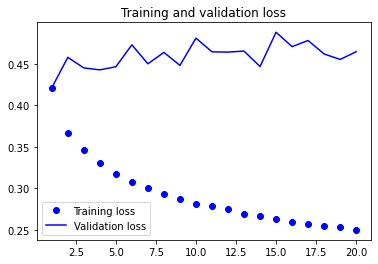

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

## 3. CNN과 RNN의 결합

In [11]:
my_step = 3

In [14]:
from tensorflow.keras.layers import GRU
model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape=(None, df.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GRU(32, dropout=0.1))
model.add(Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20,
                    validation_data=val_gen, validation_steps=val_steps)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 10s 17ms/step - loss: 0.3678 - val_loss: 0.2912
Epoch 2/20
500